In [26]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup

pd.set_option("display.max_colwidth", None)

In [27]:
# df = pd.read_csv('..\..\data\raw\StackSample\Answers.csv', encoding_errors="replace")
# with open('../../data/answers.p','wb') as f:
#     pickle.dump(df, f)

# df = pd.read_csv('..\..\data\raw\StackSample\Questions.csv', encoding_errors="replace")
# with open('../../data/questions.p','wb') as f:
#     pickle.dump(df, f)

# df = pd.read_csv('..\..\data\raw\StackSample\Tags.csv', encoding_errors="replace")
# with open('../../data/tags.p','wb') as f:
#     pickle.dump(df, f)

# Поставленные задачи
1. Избавиться от вопросов с ссылками
2. Убрать вопросы и ответы с \<img>
3. Убрать вопросы с \<pre> \<code>
4. На тест отобрать более поздние вопросы
5. Сформировать train, val, test

# Проверка данных

In [28]:
with open(f"../../data/raw/answers.p", "rb") as f:
    answers = pickle.load(f)

with open(f"../../data/raw/questions.p", "rb") as f:
    questions = pickle.load(f)

with open(f"../../data/raw/tags.p", "rb") as f:
    tags = pickle.load(f)

In [29]:
questions.rename(
    columns={"Body": "Q_Body", "Score": "Q_Score", "Title": "Q_Title"}, inplace=True
)
answers.rename(
    columns={"Body": "A_Body", "Score": "A_Score", "Id": "A_Id", "ParentId": "Id"},
    inplace=True,
)

In [32]:
len(answers)

2014516

In [13]:
tags.Tag.value_counts().head(10)

javascript    124155
java          115212
c#            101186
php            98808
android        90659
jquery         78542
python         64601
html           58976
c++            47591
ios            47009
Name: Tag, dtype: int64

In [6]:
tags.head(1)

,Id,Tag
0,80,flex


Text(0.5, 1.0, 'Tags')

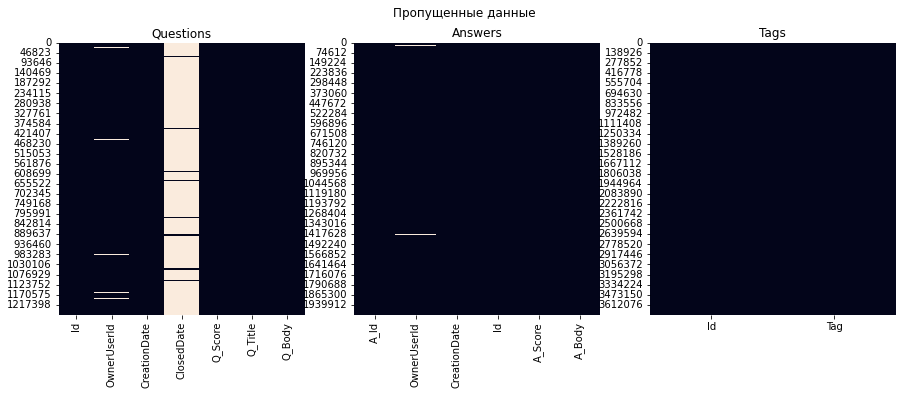

In [14]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
fig.suptitle("Пропущенные данные")

sns.heatmap(questions.isnull(), cbar=False, ax=axs[0])
sns.heatmap(answers.isnull(), cbar=False, ax=axs[1])
sns.heatmap(tags.isnull(), cbar=False, ax=axs[2])

axs[0].set_title("Questions")
axs[1].set_title("Answers")
axs[2].set_title("Tags")

__Пропусков нет__, кроме даты закрытия вопросов

# Объединение таблиц

In [33]:
tags = tags.groupby(["Id"])["Tag"].apply(list)

In [34]:
tags = tags.to_frame()

In [17]:
tags

,Tag
Id,
80,"[flex, actionscript-3, air]"
90,"[svn, tortoisesvn, branch, branching-and-merging]"
120,"[sql, asp.net, sitemap]"
180,"[algorithm, language-agnostic, colors, color-space]"
260,"[c#, .net, scripting, compiler-construction]"
...,...
40143210,"[php, .htaccess]"
40143300,[google-bigquery]
40143340,"[android, android-studio]"


In [35]:
q_a_df = pd.merge(
    questions[["Id", "CreationDate", "Q_Score", "Q_Title", "Q_Body"]],
    answers[["Id", "A_Score", "A_Body"]],
    on="Id",
    how="left",
)
q_a_df = pd.merge(
    q_a_df,
    tags[["Tag"]],
    on="Id",
    how="left",
)

In [36]:
del questions, answers

In [37]:
len(q_a_df)

2176164

# Фильтрация строк

In [38]:
q_a_df.head(1)

,Id,CreationDate,Q_Score,Q_Title,Q_Body,A_Score,A_Body,Tag
0,80,2008-08-01T13:57:07Z,26,SQLStatement.execute() - multiple queries in one statement,"<p>I've written a database generation script in <a href=""http://en.wikipedia.org/wiki/SQL"">SQL</a> and want to execute it in my <a href=""http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime"">Adobe AIR</a> application:</p>\n\n<pre><code>Create Table tRole (\n roleID integer Primary Key\n ,roleName varchar(40)\n);\nCreate Table tFile (\n fileID integer Primary Key\n ,fileName varchar(50)\n ,fileDescription varchar(500)\n ,thumbnailID integer\n ,fileFormatID integer\n ,categoryID integer\n ,isFavorite boolean\n ,dateAdded date\n ,globalAccessCount integer\n ,lastAccessTime date\n ,downloadComplete boolean\n ,isNew boolean\n ,isSpotlight boolean\n ,duration varchar(30)\n);\nCreate Table tCategory (\n categoryID integer Primary Key\n ,categoryName varchar(50)\n ,parent_categoryID integer\n);\n...\n</code></pre>\n\n<p>I execute this in Adobe AIR using the following methods:</p>\n\n<pre><code>public static function RunSqlFromFile(fileName:String):void {\n var file:File = File.applicationDirectory.resolvePath(fileName);\n var stream:FileStream = new FileStream();\n stream.open(file, FileMode.READ)\n var strSql:String = stream.readUTFBytes(stream.bytesAvailable);\n NonQuery(strSql);\n}\n\npublic static function NonQuery(strSQL:String):void\n{\n var sqlConnection:SQLConnection = new SQLConnection();\n sqlConnection.open(File.applicationStorageDirectory.resolvePath(DBPATH);\n var sqlStatement:SQLStatement = new SQLStatement();\n sqlStatement.text = strSQL;\n sqlStatement.sqlConnection = sqlConnection;\n try\n {\n sqlStatement.execute();\n }\n catch (error:SQLError)\n {\n Alert.show(error.toString());\n }\n}\n</code></pre>\n\n<p>No errors are generated, however only <code>tRole</code> exists. It seems that it only looks at the first query (up to the semicolon- if I remove it, the query fails). Is there a way to call multiple queries in one statement?</p>\n",12.0,"<p>I wound up using this. It is a kind of a hack, but it actually works pretty well. The only thing is you have to be very careful with your semicolons. : D</p>\n\n<pre><code>var strSql:String = stream.readUTFBytes(stream.bytesAvailable); \nvar i:Number = 0;\nvar strSqlSplit:Array = strSql.split("";"");\nfor (i = 0; i &lt; strSqlSplit.length; i++){\n NonQuery(strSqlSplit[i].toString());\n}\n</code></pre>\n","[flex, actionscript-3, air]"


In [39]:
def filter_column(df, column_name, text_to_filter, regex=False):
    before_filtering = len(df)
    df = df[
        ~df[f"{column_name}"].str.contains(f"{text_to_filter}", na=False, regex=regex)
    ]
    after_filtering = len(df)
    print(f"Deleted {before_filtering-after_filtering} rows")
    return df

## Строки с \<img>

In [41]:
100314 + 21649

121963

In [40]:
q_a_df = filter_column(q_a_df, "Q_Body", "<img")
q_a_df = filter_column(q_a_df, "A_Body", "<img")

Deleted 100314 rows
Deleted 21649 rows


In [22]:
len(q_a_df)

2054201

## Строки с ссылками

In [42]:
q_a_df = filter_column(q_a_df, "A_Body", "<a href=")
q_a_df = filter_column(q_a_df, "Q_Body", "<a href=")

Deleted 611897 rows
Deleted 209812 rows


In [43]:
len(q_a_df)

1232492

## Избавимся от блоков кода

In [45]:
pre_code_regex = "</code></pre>"

In [48]:
883568 + 127682 

1011250

In [46]:
q_a_df = filter_column(q_a_df, "Q_Body", pre_code_regex, regex=False)
q_a_df = filter_column(q_a_df, "A_Body", pre_code_regex, regex=False)

Deleted 883568 rows
Deleted 127682 rows


In [47]:
len(q_a_df)

221242

## Отберем вопросы и ответы с приемлемым рейтингом

In [49]:
questions_score = 1
answers_score = 1

q_a_df.query(
    f"Q_Score >= {questions_score} and A_Score >= {answers_score}", inplace=True
)

In [50]:
len(q_a_df)

71296

## Преобразуем дату

In [38]:
import datetime

In [39]:
q_a_df.CreationDate = q_a_df.CreationDate.apply(pd.to_datetime)
q_a_df.rename(columns={"CreationDate": "Q_Date"}, inplace=True)
q_a_df = q_a_df.reset_index(drop=True)

<AxesSubplot:>

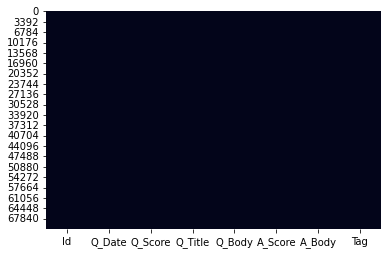

In [40]:
sns.heatmap(q_a_df.isnull(), cbar=False)

## Преобразуем Q_Body и A_Body из HTML в текст

In [51]:
q_a_df["Q_Body"] = q_a_df["Q_Body"].apply(lambda x: BeautifulSoup(x).get_text())
q_a_df["Q_Title"] = q_a_df["Q_Title"].apply(lambda x: BeautifulSoup(x).get_text())
q_a_df["A_Body"] = q_a_df["A_Body"].apply(lambda x: BeautifulSoup(x).get_text())

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


## Сохраним получившийся датасет

In [53]:
with open("../../data/prepared/filtered_df.p", "wb") as f:
    pickle.dump(q_a_df, f)

## Сделаем train/test разбиение на основе времени

In [54]:
q_a_df = q_a_df.sort_values("Q_Date")

In [55]:
train, test = np.split(q_a_df, [int(0.75 * len(q_a_df))])

In [57]:
train.to_csv("../../data/prepared/train.csv", index=False)
test.to_csv("../../data/prepared/test.csv", index=False)